### Import Statements

In [1]:
#!git clone https://github.com/jjdrisco/dsc210project.git

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk
from collections import Counter

/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
#tokenization resources
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from nltk.corpus import words
nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johndriscoll/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/johndriscoll/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
#for NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


In [5]:
#for coherence implementation
from gensim.models import Word2Vec
from itertools import combinations
from operator import itemgetter

In [6]:
#!pip install octis

In [7]:
#for topic diveristy
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

### Data Cleaning & EDA

Our dataset is a collection of 18,000 newsgroup documents from 20 different newgroups. The dataset has been split into training and testing subsets. We will be training our topic model on the larger subset, the training set. Since our algorithm is an unsupervised machine learning algorithm, we will not be using the test set. Additionally, the target values for the 20 different newsgroups will be used to assess the evaluation of our model in correctly extracting relevant topics.

In [8]:
# import dataset from sklearn and remove headers and footers for a more realistic model

from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset='train', remove=['headers', 'footers'])

Past research on this dataset has shown a tendency for topic models to overfit on headers, so we have removed them from the data. This will improve generalizability to other documents that do not follow the same format.

The data is split into document contents and targets. The 20 newsgroup targets are show below.

In [9]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

An example of a document and its corresponding newsgroup is illustrated. _Data_ includes the content of the newsgroup document, _target_ includes the index of the category of the newsgroup, and _target_names_ includes the name of the category of the newsgroup.

In [10]:
dataset.data[3]

"Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice.  It's got this\n> quadrilateral fill command that requires just the four points.\n\nDo you have Weitek's address/phone number?  I'd like to get some information\nabout this chip.\n"

In [11]:
dataset.target[3], dataset.target_names[dataset.target[3]]

(1, 'comp.graphics')

We can represent this data as a dataframe for more efficient data cleaning and data exploration.

In [12]:
newsgroup_df = pd.DataFrame({"document": dataset.data, "target": dataset.target})
newsgroup_df = newsgroup_df.assign(newsgroup=newsgroup_df["target"].apply(lambda x: dataset.target_names[x]))
newsgroup_df.head()

,document,target,newsgroup
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


Let's do some exploratory data analysis to better understand our dataset. First, we can look at the distriubtion of our newsgroup targets to see if there are any outliers.

/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Number of Corresponding Documents')

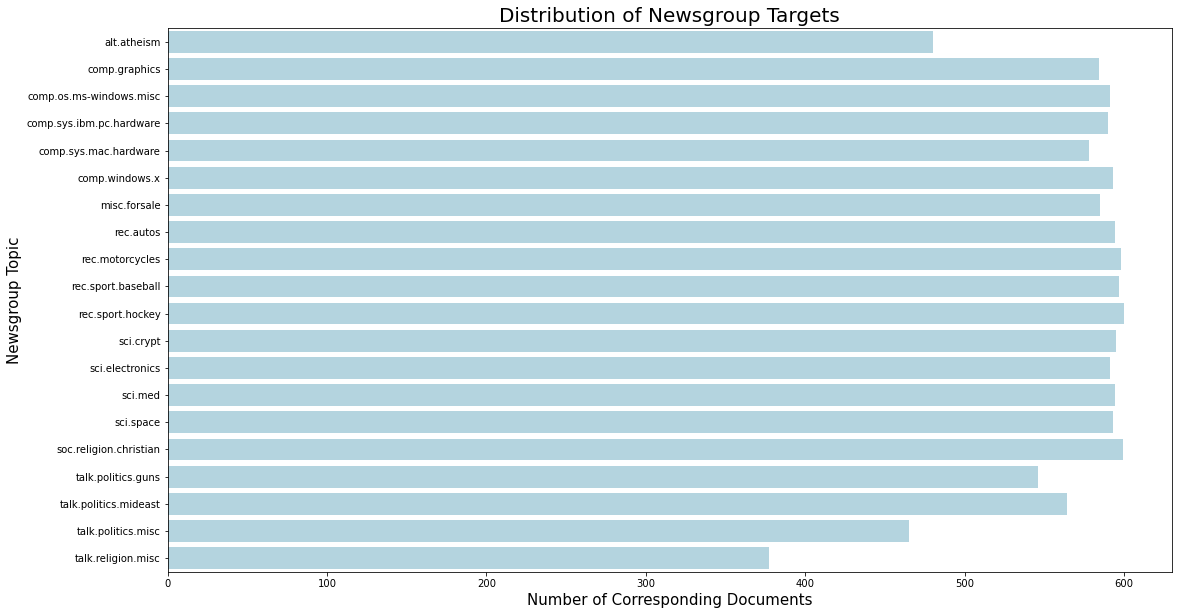

In [13]:
# plot the distribution of the newsgroups
fig1 = plt.figure(figsize =[18 ,10])
ax = sns.countplot(y=newsgroup_df['newsgroup'], color="lightblue", order=dataset.target_names)
plt.title('Distribution of Newsgroup Targets', size=20)
plt.ylabel('Newsgroup Topic', size = 15)
plt.xlabel('Number of Corresponding Documents', size = 15)

Talk.politics.misc and talk.religion.misc are more abstract, overlap with other topics like talk.politics.guns and alt.atheism, and have lower counts of associated documents. We will remove them from our training set and focus on the remaining 18 topics instead.

In [14]:
newsgroup_df = newsgroup_df[(newsgroup_df["newsgroup"] != 'talk.politics.misc') & (newsgroup_df["newsgroup"] != 'talk.religion.misc')]
newsgroup_df.shape

(10472, 3)

In [15]:
newsgroup_df["document"]

0        I was wondering if anyone out there could enli...
1        A fair number of brave souls who upgraded thei...
2        well folks, my mac plus finally gave up the gh...
3        Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...
4        From article <C5owCB.n3p@world.std.com>, by to...
                               ...                        
11309    DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310    I have a (very old) Mac 512k and a Mac Plus, b...
11311    I just installed a DX2-66 CPU in a clone mothe...
11312    In article <1qkgbuINNs9n@shelley.u.washington....
11313    Stolen from Pasadena between 4:30 and 6:30 pm ...
Name: document, Length: 10472, dtype: object

In [16]:
words_per_document = newsgroup_df["document"].apply(lambda x: len(x.split(" ")))
mean_words = words_per_document.mean()
std_words = words_per_document.std()
print("mean number of words:", mean_words, "standard deviation of number of words:", std_words)

mean number of words: 257.52320473644005 standard deviation of number of words: 645.7135193230087


In [17]:
#total number of distinct words
sum(words_per_document.unique())

1189673

In [18]:
newsgroup_df["document"].apply(lambda x: len(x.split(" "))).value_counts().sort_values()[:300]

document
714      1
823      1
789      1
1138     1
3953     1
        ..
625      1
725      1
4869     1
10554    1
631      1
Name: count, Length: 300, dtype: int64

In [19]:
print('max words per document', max(words_per_document), ', min words per document', min(words_per_document))

max words per document 20083 , min words per document 1


{'whiskers': [<matplotlib.lines.Line2D at 0x7f7a4e4bb1f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7a4e4bb850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7a4e4a4d60>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7a4e4bbf70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7a4e4c7340>],
 'means': []}

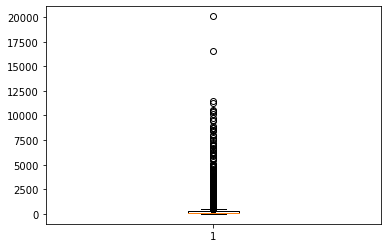

In [20]:
plt.boxplot(words_per_document)

We can now preprocess the data for the topic model. We will first clean the documents by removing punctation, numbers, and characters, converting to lowercase, and stripping empty strings. We will also remove non-descriptive words such as "a", "is", "from", "and", etc. We will add additional stop words that occur often in our dataset but do not have any significant meaning for the theme extraction. Lastly, we will lemmatize our documents, meaning we will distill words into their foundational terms, like "running" to "run". This will help reduce unnecessary and redundant terms and ensure a faster runtime.

In [21]:
# List of stop words
additional_stop_words = set(["article", "subject", 'time','im','thing', 'new', 'said', 'need', 'want', 'did',
                             'know','like','people','think','writes','just','dont', '___', 'good', 'used',
                            "use", "think", 'doe', "year", "say", "make", 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax'])
stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)

# Splits words on white spaces
def tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def process_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation, numbers, \n, and extra whitespaces
    text = re.sub(r'\d+|[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'\s{2,}', ' ', text)
    # only include english dictionary words
    # Tokenize and lemmatize
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(word) for word in tokenizer(text) if word not in stop_words]
    text = [each for each in tokens if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return " ".join(text)

In [22]:
# Set options to display all rows and columns
newsgroup_df['document'][1]

"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks."

In [23]:
newsgroup_df['document'][:10].apply(process_text)

0    wondering enlighten car saw day door sport car...
1    fair number brave soul upgraded si clock oscil...
2    folk mac plus finally gave ghost weekend start...
3    robert jc kyanko robrjckuucp wrote abraxisiast...
4    cowcbnpworldstdcom tombakerworldstdcom tom bak...
5    reuttransferstratuscom cdtswstratuscom tavares...
6    responded request info treatment astrocytomas ...
7    dxbpsuvmpsuedu qlbrlinnrkdnsnmsuedu bgrubbdant...
8    win downloaded icon bmps figure change wallpap...
9    jappocwruedu joseph pellettiere looking inform...
Name: document, dtype: object

In [24]:
### tokenize the abstracts
newsgroup_df['processed_documents'] = newsgroup_df['document'].apply(process_text)
newsgroup_df['processed_documents']

0        wondering enlighten car saw day door sport car...
1        fair number brave soul upgraded si clock oscil...
2        folk mac plus finally gave ghost weekend start...
3        robert jc kyanko robrjckuucp wrote abraxisiast...
4        cowcbnpworldstdcom tombakerworldstdcom tom bak...
                               ...                        
11309    dn nyedacnsvaxuwecedu david nye dn neurology d...
11310    old mac mac plus problem screen blank minor ph...
11311    installed dx cpu clone motherboard tried mount...
11312    qkgbuinnsnshelleyuwashingtonedu bolsoncarsonuw...
11313    stolen pasadena pm blue white honda cbrrr cali...
Name: processed_documents, Length: 10472, dtype: object

In [25]:
# Get the top 20 most common words among all the documents

p_text = ' '.join(newsgroup_df['processed_documents'].tolist())

p_text = p_text.split(' ')

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,doe,3508
1,file,2821
2,right,2809
3,problem,2806
4,way,2586
5,work,2475
6,window,2402
7,god,2307
8,question,2042
9,program,1952


In [26]:
top_20['word'][15]

'game'

In [27]:
def pre_process_test():
    """
    Callable function to process 20newsgroups test data.
    Summarizes steps done above
    """
    #pull the data
    test_dataset = fetch_20newsgroups(subset='test', remove=['headers', 'footers'])

    #put into dataframe
    test_newsgroup_df = pd.DataFrame({"document": test_dataset.data, "target": test_dataset.target})
    test_newsgroup_df = test_newsgroup_df.assign(newsgroup=test_newsgroup_df["target"].apply(lambda x: test_dataset.target_names[x]))

    #remove redundant groups
    test_newsgroup_df = test_newsgroup_df[(test_newsgroup_df["newsgroup"] != 'talk.politics.misc') & (test_newsgroup_df["newsgroup"] != 'talk.religion.misc')]

    #process text
    test_newsgroup_df['processed_documents'] = test_newsgroup_df['document'].apply(process_text)

    return test_newsgroup_df

test_newsgroup_df = pre_process_test()

### NMF - Manual Topic Number

#### Model Training

Transform lemmatized and cleaned words into a document-term frequency matrix (DTM)

In [28]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)

# Fit and transform the processed abstracts into DTM
dtm = vectorizer.fit_transform(newsgroup_df['processed_documents'])

In [29]:
def do_nmf(n_topics):

    # Specify the number of topics
    nmf_model = NMF(n_components=n_topics)
    W = nmf_model.fit_transform(dtm)  # Document-topic matrix   (n_samples, n_components)
    H = nmf_model.components_         # Topic-term matrix       (n_components, n_features)
    return nmf_model, W, H

In [30]:
n_topics = 18
nmf_model, W, H = do_nmf(n_topics)

/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [31]:
feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(H):
    print(f"Topic #{index + 1}:")
    print(",".join([feature_names[i] for i in topic.argsort()[-10:]]))  # Top 10 words per topic

Topic #1:
going,honda,dod,helmet,rider,dog,riding,ride,motorcycle,bike
Topic #2:
running,run,using,version,font,program,manager,application,do,window
Topic #3:
tape,meg,boot,cdrom,switch,cable,jumper,floppy,hard,drive
Topic #4:
fan,league,baseball,hockey,season,win,play,player,team,game
Topic #5:
secure,algorithm,bit,phone,government,escrow,clipper,encryption,chip,key
Topic #6:
church,truth,belief,atheist,faith,bible,believe,jesus,christian,god
Topic #7:
machine,computer,norton,hard,problem,software,boot,floppy,do,disk
Topic #8:
bus,vesa,vga,graphic,mode,ati,diamond,video,driver,card
Topic #9:
information,help,address,doe,info,looking,hi,advance,email,thanks
Topic #10:
policy,state,lebanon,peace,lebanese,palestinian,jew,arab,israeli,israel
Topic #11:
site,convert,gif,bmp,ftp,image,directory,format,program,file
Topic #12:
police,state,government,crime,criminal,firearm,weapon,law,right,gun
Topic #13:
azerbaijan,azeri,muslim,greek,genocide,turk,turkey,armenia,turkish,armenian
Topic #14:
p

In [32]:
# Let's say we want the topic distribution for the first document (index 0)
document_index = 10
document_topics = W[document_index]  # Get topic weights for this document

# Identify the dominant topic for this document
dominant_topic = np.argmax(document_topics)

print(f"Document #{document_index + 1} dominant topic: Topic {dominant_topic + 1}")
print(f"Topic Distribution for Document #{document_index + 1}:")
for topic_idx, weight in enumerate(document_topics):
    print(f"Topic {topic_idx + 1}: {weight:.4f}")

# Print the top words for the dominant topic to understand its meaning
top_word_indices = H[dominant_topic].argsort()[-10:]  # Top 10 words for the dominant topic
print(f"\nTop words for Dominant Topic {dominant_topic + 1}:")
print(" ".join([feature_names[i] for i in top_word_indices]))
print(newsgroup_df.iloc[document_index]["newsgroup"])
print(newsgroup_df.iloc[document_index]["document"])

Document #11 dominant topic: Topic 1
Topic Distribution for Document #11:
Topic 1: 0.0537
Topic 2: 0.0000
Topic 3: 0.0015
Topic 4: 0.0000
Topic 5: 0.0000
Topic 6: 0.0000
Topic 7: 0.0007
Topic 8: 0.0000
Topic 9: 0.0231
Topic 10: 0.0000
Topic 11: 0.0000
Topic 12: 0.0000
Topic 13: 0.0000
Topic 14: 0.0063
Topic 15: 0.0016
Topic 16: 0.0000
Topic 17: 0.0093
Topic 18: 0.0038

Top words for Dominant Topic 1:
going honda dod helmet rider dog riding ride motorcycle bike
rec.motorcycles
I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
-----------------------------------------

#### Coherence Score for NMF

Coherence score measures the relative distance between words within a topic.

##### TC-W2V Implementation for SKLearn
Source: https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

<b>Build a Word Embedding</b>

To select the number of topics, here we will use a topic coherence measure called TC-W2V. This measure relies on the use of a word embedding model constructed from our corpus. So in this step we will use the Gensim implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

In [33]:
# #First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

# class TokenGenerator:
#     def __init__(self, documents, stopwords):
#         self.documents = documents
#         self.stopwords = stopwords
#         self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

#     def __iter__(self):
#         print("Building Word2Vec model ...")
#         for doc in self.documents:
#             tokens = []
#             for tok in self.tokenizer.findall( doc ):
#                 if tok in self.stopwords:
#                     tokens.append( "<stopword>" )
#                 elif len(tok) >= 2:
#                     tokens.append( tok )
#             yield tokens

In [34]:
# # Now build a Skipgram Word2Vec model from all documents in the input file using Gensim:

# raw_documents = newsgroup_df['processed_documents']
# custom_stop_words = stop_words

# docgen = TokenGenerator(raw_documents, custom_stop_words)
# # the model has 500 dimensions, the minimum document-term frequency is 20
# w2v_model = Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

# # Save for later use, so that we do not need to rebuild it:
# # w2v_model.save("w2v-model.bin")

# print("Model has %d terms" % len(w2v_model.wv.key_to_index))

In [35]:
# To re-load this model, run
# for google colab
#w2v_model = Word2Vec.load("dsc210project/w2v-model.bin")
w2v_model = Word2Vec.load("w2v-model.bin")

<b>Selecting the Number of Topics</b>

Once we have our Word2vec model, we can use it as part of our topic coherence approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.


In [61]:
# We use the Word2vec model to calculate coherence scores for each of these models.
# We will define this coherence score as follows:

def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            try: # sometimes a term NMF identified may not have been identified by w2v
                pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
            except:
                None
        # if there are no scores, none of the words were captured by w2v
        if len(pair_scores) == 0:
            continue
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

#We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [37]:
def do_coherence(k, W, H, terms=feature_names):
    """Generates a final coherence score for a NMF model"""
    # where k is number of topics

    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    global temp_top_terms
    temp_top_terms = term_rankings
    curr_coherence = calculate_coherence( w2v_model, term_rankings )
    print("K=%02d: Coherence=%.4f" % ( k, curr_coherence ) )
    return curr_coherence

In [38]:
do_coherence(18, W, H)

K=18: Coherence=0.4866


0.4865590388806145

end sourced code

### NMF - Automatic Topic Number

In practice, a model will not know a-priori the true number of topics in a set, so coherence score can be used as a measure to choose the best topic model across multiple numbers of topics.

In [ ]:
# Create a list of the topic numbers we want to try
topic_nums = np.arange(10, 30, 2)
coherence_scores = dict()
nmf_models = dict()

for k in topic_nums:
    curr_model, curr_W, curr_H = do_nmf(k)
    nmf_models[k] = (curr_W, curr_H)
    coherence_scores[k] = do_coherence(k, curr_W, curr_H)

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores.values()))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics, coherence_scores[best_num_topics])

K=10: Coherence=0.4485
K=12: Coherence=0.4756
K=14: Coherence=0.4793
K=16: Coherence=0.4819


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=18: Coherence=0.4947


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=20: Coherence=0.5083
K=22: Coherence=0.5113
K=24: Coherence=0.5073
K=26: Coherence=0.5259
K=28: Coherence=0.5209
26 0.5259123247084964


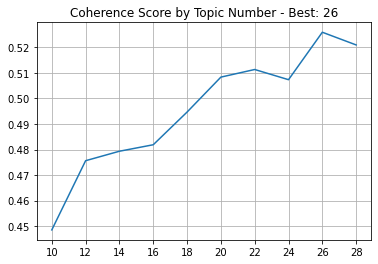

In [ ]:
plt.plot(topic_nums, coherence_scores.values())
plt.title("Coherence Score by Topic Number - Best: {}".format(best_num_topics))
plt.grid(True)
plt.xticks(topic_nums)
plt.show()

The model chosen by hyperparameter optimization on coherence would have 26 parameters.

### NMF - Evaluation

For our evaluation of NMF, we use NMF with a manually selected 18 topics for ease of interpretation unless otherwise specified.

#### Residual Score (NMF only)

"Residuals are differences between the observed and predicted values of the data. A residual of 0 means the topic perfectly approximates the text of the article, so the lower the better.

To calculate the residual you can take the Frobenius norm (square root of the sum of the absolute squares of its elements) of the tf-idf weights (A) minus the dot product of the coefficients of the topics (H) and the topics (W). We can then get the average residual for each topic to see which has the smallest residual on average." - https://freedium.cfd/https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
<br><br><br>
How well do the topics approximate the original weights of the tfidf matrix for each document?
Averaged across topics, can get the sense of how good of an approximator each topic is.

Residual $[x_i]$ $\lVert x_i - W_i H\rVert _F$ where document $x_i \in$ documents $X$, $W_i$ is row i of the Document-topic matrix and $H$ is the Topic-term matrix, $F$ represents Frobenius norm

In [ ]:
# For each document calculate the difference between the original tfidf weights and those predicted
# by multiplying W and H for that specific row.
# Cell Source: https://freedium.cfd/https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
def do_residual(dtm, W, H):
    residuals = np.zeros(dtm.shape[0])
    for row in range(dtm.shape[0]):
        # 'fro' here means we are using the Frobenium norm as the distance metric
        residuals[row] = np.linalg.norm(dtm[row, :] - W[row, :].dot(H), 'fro')
    return residuals

residuals = do_residual(dtm, W, H)
residuals

array([0.86996536, 0.98171994, 0.95922364, ..., 0.99335532, 0.98736501,
       0.99289406])

In [ ]:
np.mean(residuals)

0.9708446389530064

Text(0.5, 1.0, 'Average Residual per Document by Main Topic')

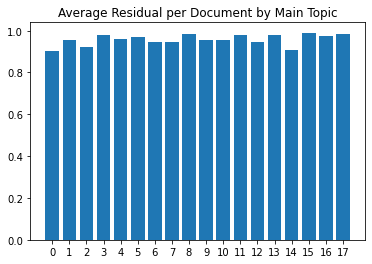

In [ ]:
residuals_by_topic = pd.Series(residuals).groupby(np.argmax(W, axis=1)).mean()
plt.bar(x=residuals_by_topic.index, height=residuals_by_topic.values)
plt.xticks(residuals_by_topic.index)
plt.title("Average Residual per Document by Main Topic")

Residuals are nearly indistinguishable by visualization.

In [ ]:
residuals_by_topic.sort_values(ascending=False)

15    0.990236
8     0.984835
17    0.983434
11    0.981562
3     0.980905
13    0.979958
16    0.974065
5     0.970011
4     0.957961
10    0.954941
9     0.954250
1     0.953899
6     0.947701
7     0.946102
12    0.943613
2     0.922046
14    0.906730
0     0.902853
dtype: float64

Topic 0 has the lowest residual while topic 15 has the highest.

<b>Using Residual to Compare NMF Models</b>

In [ ]:
# manually selected had residual of 0.98
# calculate residual on "best" model chosen by coherence score (26 topics)
np.mean(do_residual(dtm, list(nmf_models.values())[-2][0], list(nmf_models.values())[-2][1]))

0.9649444927577222

The matrix chosen by coherence score has a worse residual than the one chosen with 18 features, indicating that selecting by coherence score may not result in the best decomposition, but it is standard practice at the moment.

#### "Expert" Manual Evaluation

Note: These types of manual investigations can serve as sanity checks but don't tell us much about how good a topic model would be for a given task.

<b>Instance Inspection</b>

Since relevance is difficult to interpret without a baseline, we compare the two for quality below by inspecting sets of training instances.

In [ ]:
chosen_topic_1 = np.random.choice(np.array(range(dtm.shape[0]))[np.argmax(W, axis=1)==1], size=5, replace=False)
display([feature_names[i] for i in H[1].argsort()[-10:]])
for i, content in newsgroup_df['document'].iloc[chosen_topic_1].items(): display((i, content))
chosen_topic_2 = np.random.choice(np.array(range(dtm.shape[0]))[np.argmax(W, axis=1)==2], size=5, replace=False)
display([feature_names[i] for i in H[2].argsort()[-10:]])
for i, content in newsgroup_df['document'].iloc[chosen_topic_2].items(): display((i, content))

['running',
 'run',
 'using',
 'version',
 'font',
 'program',
 'manager',
 'application',
 'do',
 'window']

(5749,
 'Consumer Reports once wrote about the S-10 Blazer that it "shook and rattled\nlike a tired taxi cab".  There is one noise that is expecially irritating -\nthe back window squeaks.  I believe its because the whole tailgate assembly\nand window are not solid.  Anyway, has anyone had the same problem, and have\nyou found any fixes?')

(1157,
 "comp.windows.x\nIn article <1993Apr26.122007.25760@relay.nswc.navy.mil>, rchui@nswc-wo.nswc.navy.mil (Raymond Chui) writes:\n\n\tPlease igore my previouse calculation mistaked. Please see the correct\ncalculation. Sorry!\n|> I created a pixmap or drawable window, then used XDrawLine() function \n|> drawed a line as below fingure:\n|> \n|> \t\twidth = 300\n|> \t================================\n|> \t|\t\t\t\t|\n|> \t|\t\t\t\t|\n|> \t|\t\t\tp1\t|\n|> \t|\t\t\t\\\t|\n|> \t|\t\t\t \\\t| height = 300\n|> \t|\t\t\t  \\\t|\n|> \t|\t\t\t   \\\t|\n|> \t|\t\t\t    \\\t|\n|> \t|\t\t\t     \\\t|\n|> \t|\t\t\t      \\\t|\n|> \t|\t\t\t       \\|p3\n|> \t|\t\t\t\t| \n|> \t|===============================| \\\n|> \t\t\t\t\t    \\\n|> \t\t\t\t\t     p2\n|> \n|> \tI created the pixmap or drawable window only with size 300x300.\n|> But I draw line from p1(x1=270,y1=100) to p2(x2=500,y2=800).\n|> My question is, dose the XDrawLine function can finger out that correct\n|> p3(x3 and y3) for me? If 

(1118,
 "I am developing an X (Xt,Xm) application that will include a graphics window\nof some sort with moving symbols among other things.  A pure X application\ncould be implemented with Motif widgets, one of which would be an \nXmDrawingArea for drawing with Xlib.  But I would like to take advantage of\nthe Graphics Library (GL) available on our IBM RS/6000 (SGI's GL i believe).\n\nIs it possible to mix X and GL in one application program?\nCan I use GL subroutines in an XmDrawingArea or in an X window opened by me\nwith XOpenWindow?\n\nI have never used GL before, but the doc on GL winopen() says that the first\ntime winopen() is called it opens a connection to the server.   Also, most of\nthe GL calls do not require a Display or GC, unlike most X calls.  From this\ninitial information it appears that X and GL cannot be mixed easily.   Is this\ntrue?\n\nDoes PEX (graPHIGS?) have the same functionality of GL?\n\n\nEnvironment:\n     AIXwindows X11R4\n     Motif 1.1\n     GL is avail

(8705,
 'I have a 486DX33 ISA system with 4 meg.  I am using a Diamond Speedstar HiColor\nvideo card with 1 meg VRAM and a standard CTX 14-in SVGA monitor.  When I am\nrunning Windows, and I have overlapping windows (say an application overlapping\nthe program manager window), and I close the active application, window erasure\nis very slow.  The part of the window that is not overlapping is erased first,\nvery slowly.  This also happens when I iconify an application.\n\nThe HiColor card is advertised as a faster-than-standard video card, but it\ndoes not have an accelerator chip on it.  I am running at 800x600x32k.  Is this\nslow speed simply to be expected without an accelerator chip, or is there\nsomething else that is bottlenecking the system that I am unaware of?\n\nThanks.')

(3716,
 "In Windows I created a permanent Swap-file of 7771Kb as win3.1\nrecommended me to do that (32bit access).\nIf I use EMM386.EXE, after win3.1 startup I have 6689K of memory\nfree, if I leave EMM386.EXE out of my config.sys I have 9935K\nof memory free, and windows recommends me a swap file of 11769K.\n\nI use DOS6, with memmaker, have 4MB of internal Memory and a 486DX,\n\nDoes anybody knows why this is happening (possibly win needs\nsome UMB's to manage virtual memory?, If true, which UMB's, those\nthat EMM386 can find without including suspicious parts?)\n\nI need an optimized DOS-environment, because i develop applications for\nDOS using a windows programming environment.\n")

['tape',
 'meg',
 'boot',
 'cdrom',
 'switch',
 'cable',
 'jumper',
 'floppy',
 'hard',
 'drive']

(8908,
 'MJMUISE@1302.watstar.uwaterloo.ca (Mike Muise) writes:\n\n> In article <C4wKBp.B9w@eskimo.com>, maven@eskimo.com (Norman Hamer) writes:\n> >  What is a general rule of thumb for sobriety and cycling? Couple hours \n> > after you "feel" sober? What? Or should I just work with "If I drink \n> > tonight, I don\'t ride until tomorrow"?\n> \n> 1 hr/drink for the first 4 drinks.\n> 1.5 hours/drink for the next 6 drinks.\n> 2 hours/drink for the rest.\n\nI took an alcohol server\'s class a few years ago.  (What the hey- my employer\npaid for it...)\n\nWe were told that the 1 drink / hour rule was written with 80 proof booze\nand a 195 pound person in mind.  Drinking Cuervo Gold, weighing in @ 140,\nI obviously will get drunk faster than the theoretical person mentioned\nabove.  Worse, imagine Rum & coke made with Bacardi 151...\n\nMind you all, that\'s for getting too drunk to drive a car.  I may only\nhave been riding for a month or so, but I plan my evenings with a very\nrigid excl

(8263,
 'Greetings all...\n\nCould some kind sole email me the specs for a Western Digital drive?\n\nIt is Model # WD93044-A with 782 cyl and 4 hds.  But I do not know the\nsectors per track, or any of the other information I have to feed to my\nbios to get it up and running.\n\nThanx for any help\nBob K.\n\nroking@lynx.dac.northeastern.edu')

(2981,
 "Hi there!\n\nWhat is your recommendation for a good hard-disk driver software for\nnon-Apple drives? I would mainly need it for a SyQuest removable media\ndrive, but maybe for some normal drives too.\nI have heard and seen good things about SilverLining, but don't know\nany competitors. It does not need to be fancy, filled with features...\nI more like it affordable.\n\nThanks\n")

(6659,
 'I have a 486 machine with a 3.5" A: drive and a 5.25" B: drive.  I\nwant to swap them so 3.5" drive is A:  What do I have to do?\n\nTIA\n')

(4267,
 'HELP, PROBLEM 486/33MHZ HANGS IN EXTENDED MODE TRYING TO\nACCESS DRIVES A: OR B: , SOMETIMES IT WILL DO DIR , SOMETIMES WILL HANG\nON ACCESS SOMETIMES WILL WHEN TYING A TEXT FILE.\n\nHARDWARE:\nAMERICAN MEGATREND MOTHERBOARD\nAMI BIOS 91\nCONNER 85MB HARD DRIVE\nTRIDENT 1 MEG SVGA')

Both topics seem to be representative of the randomly chosen instances best explained by that topic.

<b>Comparative Visualization</b>

We can also see how the generated topics relate to the new topics.

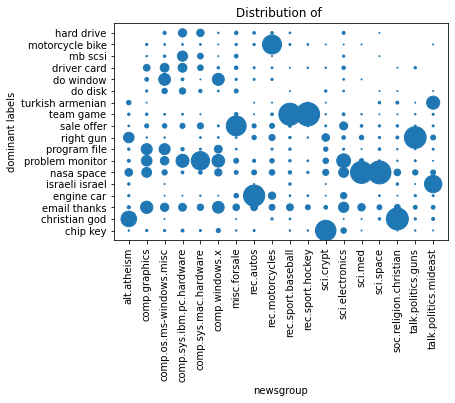

In [ ]:
def plot_topic_match_nmf(W, H):
    nmf_group_df = newsgroup_df.copy()
    #dominant topic for each instance
    nmf_group_df['dominant topic'] = np.argmax(W,axis=1)
    top_two_labels = H.argsort(axis=1)[:,-2:]
    nmf_group_df['dominant labels'] = nmf_group_df['dominant topic'].apply(
            lambda x: " ".join([feature_names[i] for i in top_two_labels[x]])
        )
    topic_match_df = nmf_group_df.groupby(['newsgroup', 'dominant labels']).count().reset_index()
    topic_match_df.plot.scatter(
        x='newsgroup', y='dominant labels', s='document')
    plt.xticks(rotation='vertical');
    plt.title("Distribution of ")
    plt.plot()
    return nmf_group_df, topic_match_df

nmf_group_df, topic_match_df = plot_topic_match_nmf(W, H);

Some of the NMF categories map directly to original newsgroups, like "team, game" maps to baseball and hockey with high frequency. So does "nasa, space" to medicine and space. However, other topics did not capture the original newsgroups well.

#### Topic Diversity

Topic diversity measures how distinct the topics are from each other, based on their overlap or similarity.

"The more diverse the resulting topics are, the higher will be the coverage of the various aspects of the analyzed corpus. It is therefore important to also obtain topics that are different from each other (rather than just considering how much coherent the topics are)." -Silvia Terragni (https://github.com/silviatti/topic-model-diversity)

In [67]:
top_ten_labels = H.argsort(axis=1)[:,-10:]
nmf_topics_output = dict()
nmf_topics_output['topics'] = [[feature_names[i] for i in x] for x in top_ten_labels]

In [68]:
metric = TopicDiversity(topk=10) # Initialize metric
topic_diversity_score_nmf_18 = metric.score(nmf_topics_output) # Compute score of the metric
topic_diversity_score_nmf_18

0.9111111111111111

Let's compare this to the coherence-picked nmf:

In [ ]:
top_ten_labels = list(nmf_models.values())[-2][1].argsort(axis=1)[:,-10:]
nmf_topics_output = dict()
nmf_topics_output['topics'] = [[feature_names[i] for i in x] for x in top_ten_labels]
topic_diversity_score_nmf_26 = metric.score(nmf_topics_output) # Compute score of the metric
topic_diversity_score_nmf_26

0.8769230769230769

The diversity of the nmf picked by coherence is also lower. This is expected because there is a lower number of topics.

#### Predictive Utility

The best way to measure how useful topic groups are would be to measure their predictive accuracy on a new set of data. However, since the new topics don't match back to the original labels we can't do this for the 20 newsgroups dataset. If we try to match them back to the original measure the accuracy is abysmal.

In conclusion, <b>unless we are comparing topic models for a specific use case, their true usefulness will be near-possible to evaluate.<b>

Nevertheless, here's what happens if we try to map the topics back:

In [ ]:
def get_predictions(model, X, vectorizer):
    vectors = vectorizer.transform(X)#.todense() # (documents, vocab)
    display(vectors)
    predictions = model.transform(vectors)
    predictions = np.argmax(predictions, axis=1)
    return predictions

In [ ]:
#test data created in preprocessing section - test_newsgroup_df
test_vectors = test_newsgroup_df['processed_documents']
get_predictions(model=nmf_model, X=test_vectors, vectorizer=vectorizer).shape, test_newsgroup_df['target'].reset_index(drop=True)

<6971x36176 sparse matrix of type '<class 'numpy.float64'>'
	with 431499 stored elements in Compressed Sparse Row format>

((6971,),
 0        7
 1        5
 2        0
 3       17
 4       13
         ..
 6966    14
 6967     4
 6968     9
 6969     6
 6970    15
 Name: target, Length: 6971, dtype: int64)

In [ ]:
# utility dictionary that maps dominant topic label back to its nmf topic number
nmf_label_back_to_topic = nmf_group_df.groupby('dominant labels').first()['dominant topic'].to_dict()

In [ ]:
# utility map for predicted topics back to original topics, based on which original topic most likely per predicted
# Group by 'group' and get the most frequent string in 'value'
topic_map = topic_match_df.groupby('dominant labels')['newsgroup'].agg(lambda x: np.argmax(x.value_counts().index)).reset_index()
topic_map['dominant topic'] = topic_map['dominant labels'].apply(lambda x: nmf_label_back_to_topic[x])
map_topic_to_newsgroup = topic_map[['dominant topic', 'newsgroup']].set_index('dominant topic')['newsgroup'].to_dict()

In [ ]:
# compute pred accuracy for most likely original topic
# compare true test categories to mapped back labels of nmf dominant topics
np.mean(
        test_newsgroup_df['target'].reset_index(drop=True) == \
        np.array([map_topic_to_newsgroup[x] for x in \
                get_predictions(model=nmf_model, X=test_vectors, vectorizer=vectorizer)])
    )

<6971x36176 sparse matrix of type '<class 'numpy.float64'>'
	with 431499 stored elements in Compressed Sparse Row format>

0.048199684406828286

The ability to map back is incredibly weak with an accuracy of 5%. Predictive utility for the original topics is negligible.

### BERTopic

In [40]:
#! pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00


In [ ]:
#https://stackoverflow.com/questions/76313592/import-langchain-error-typeerror-issubclass-arg-1-must-be-a-class
#! pip install typing-inspect==0.8.0 typing_extensions==4.5.0

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [39]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

2024-11-29 23:55:32.226618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#! pip install -U tbb --ignore-installed

  Using cached tbb-2021.10.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl.metadata (989 bytes)
Using cached tbb-2021.10.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl (640 kB)
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# uncomment to retrain model, model loads in cell below
# representation_model = KeyBERTInspired()
# bertopic_model = BERTopic(#nr_topics = 'auto',
#     representation_model = representation_model,
#     verbose=True
# )

# bertopic_topics, bertopic_probs = bertopic_model.fit_transform(newsgroup_df['processed_documents'])

# bertopic_model.save("bertopic_model", serialization="safetensors")

2024-11-30 02:06:15,903 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/328 [00:00<?, ?it/s]

2024-11-30 02:19:03,231 - BERTopic - Embedding - Completed ✓
2024-11-30 02:19:03,233 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-30 02:19:14,389 - BERTopic - Dimensionality - Completed ✓
2024-11-30 02:19:14,392 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-30 02:19:14,853 - BERTopic - Cluster - Completed ✓
2024-11-30 02:19:14,863 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-30 02:20:59,212 - BERTopic - Representation - Completed ✓


In [40]:
bertopic_model = BERTopic.load("bertopic_model")

In [41]:
bertopic_model.visualize_topics()

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [42]:
bertopic_model.visualize_heatmap()

In [63]:
def do_coherence_bertopic(bertopic_topics, terms=feature_names):
    """Generates a final coherence score for a NMF model"""
    # where k is number of topics

    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = bertopic_topics
    curr_coherence = calculate_coherence( w2v_model, term_rankings )
    print("K=%02d: Coherence=%.4f" % ( len(term_rankings), curr_coherence ) )
    return curr_coherence

In [64]:
bertopic_topics = np.array(list(bertopic_model.topic_representations_.values()))[:,:,0]

In [ ]:
# Coherence Score
do_coherence_bertopic(bertopic_topics)

K=132: Coherence=0.6069


0.6068515515793967

In [72]:
# Topic Diversity
temp_df = dict()
temp_df['topics'] = bertopic_topics
metric.score(temp_df)

0.8151515151515152

In [43]:
bertopic_model_18 = BERTopic.load("bertopic_model").reduce_topics(newsgroup_df['processed_documents'], nr_topics=18)

2024-11-29 23:56:21,747 - BERTopic - Topic reduction - Reducing number of topics
2024-11-29 23:56:23,159 - BERTopic - Topic reduction - Reduced number of topics from 132 to 18


In [44]:
bertopic_model_18.visualize_topics()

In [46]:
bertopic_model_18.visualize_barchart(top_n_topics=18)

In [52]:
np.array(list(bertopic_model_18.topic_representations_.values()))[:,:,0]

array([['file', 'window', 'doe', 'image', 'work', 'problem', 'available',
        'program', 'db', 'version'],
       ['god', 'right', 'key', 'armenian', 'doe', 'law', 'gun', 'way',
        'believe', 'government'],
       ['drive', 'scsi', 'window', 'card', 'problem', 'mb', 'disk',
        'driver', 'printer', 'controller'],
       ['game', 'team', 'player', 'season', 'play', 'pt', 'win',
        'hockey', 'league', 'period'],
       ['car', 'bike', 'dog', 'helmet', 'speed', 'engine', 'mile',
        'right', 'ride', 'motorcycle'],
       ['price', 'sale', 'game', 'art', 'cover', 'copy', 'st', 'cd',
        'offer', 'appears'],
       ['radar', 'detector', 'sound', 'channel', 'speaker', 'scope',
        'receiver', 'radio', 'car', 'input'],
       ['space', 'launch', 'satellite', 'mission', 'nasa', 'orbit',
        'lunar', 'data', 'shuttle', 'technology'],
       ['window', 'widget', 'color', 'problem', 'client', 'server',
        'expose', 'display', 'event', 'error'],
       ['file

In [56]:
do_coherence_bertopic(bertopic_model_18)

K=18: Coherence=0.4683


0.4683074310633011